# TensorFlow Tutorial: Neural Network for Classification with Mini-Batch Gradient Descent.

### Author: Ivan Bongiorni, Data Scientist at GfK.

[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/), personal email: ivanbongiorni@gmail.com




In [the first notebook](https://github.com/IvanBongiorni/TensorFlow_Tutorial/blob/master/TensorFlow_1_Classification_BatchGD.ipynb) of this [TensorFlow tutorial series](https://github.com/IvanBongiorni/TensorFlow_Tutorial), I showed how to implement a "simple" feed-forward Neural Network for classification. This one can be seen as the **Mini-Batch Gradient Descent version** of the previous.

This model is a **Neural Network for Classification** based on the University of Wisconsin's **breast cancer dataset**.

It represents a tutorial on basic **TensorFlow**.

## First of all: WHY Mini-Batch Gradient Descent?

Mini-Batch Gradient Descent is of fundamental importance for Machine Learning in general, and Deep Learning in particular.

**It consists in feeding, at each iteration of the Gradient Descent, only a subset of (i.e.: a mini-batch) of the training data. At each iteration, mini-batch gradient descent will take a different mini-batch of data, and train just on that one.**

This technique presents at least three advantages:

1. It prevents the optimization algorithm to end up stuck into some local optima of the loss function.

2. It allows for **a significant drop in computational times**. That is because the optimizer trains the network just on a mini-batch of data, requiring much less computational effort. Often Data Scientists are dealing with massive amounts of data, and training a model on the whole train dataset at each epoch might require prohibitive computational times. That is why, for very large, datasets, Mini-Batch Gradient Descent becomes a necessary tool.

3. It is the mandatory technique for [online learning](https://en.wikipedia.org/wiki/Online_machine_learning).

## Import data from UCI ML repository

The purpose of this dataset is to classify breast cancer cases between **malignant** (**M**), and **benign** (**B**). Therefore, my classification network will have two output nodes.

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


bc_dat = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", sep=",", header=None)

## Some (vey basic) Dataprep

Dataprep is very quick for this toy dataset. I separate explanatory variables (**matrix of independent variables IVs**) and the vector of the **dependent variable** (**DV**) that contains the target categories, and then perform **One-Hot Encoding** (required for classification tasks) on this one. Finally, turn the data into numpy arrays.

In [0]:
# The first column is a simple id - and must be discarded
# 

IVs = bc_dat.iloc[:,2:31]

DV = bc_dat.iloc[:,1]

DV = pd.get_dummies(DV)  # One-Hot Encoding

# Turn the data into numpy objects
IVs = IVs.values
DV = DV.values


Explanatory variables require normalization, in order to improve the efficiency of the network and avoid imbalance between different weights.

## Train-Test split

In an actual ML job, you would split your dataset in **Train**, **Test**, and **Validation sets**. However, this is just an example on how to implement and run a Neural Network, so I'll skip that part and will split the data in train and test only.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(IVs, DV, test_size=0.25, random_state=173)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(426, 29) (426, 2)
(143, 29) (143, 2)


In [0]:
# Scale the variables using Z-scores

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # generate a scaler object

X_train = scaler.fit_transform(X_train) # the scaler object learns the mean and std of X_train

X_test = scaler.transform(X_test) # and scales X_test as well using the parameters of X_train

# Architecture

In order to implement Mini-Batch learning, I need to write a function that, at each epoch, takes single mini-batches from the training dataset, and fetches them into the network.
This requires the data to be shuffled, since we want the Mini-Batch sampling to be perfectly random.

In [0]:
# Shuffle the data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=123)   # reshuffle is done just the train set, the test must always be evaluated as a whole


def fetch_batch(X, y, epoch):
    '''
    Extracts mini-batches of given size from a dataset - different for each epoch
    Returns the train Mini-Batch and the corresponding test Mini-Batch
    '''
    X_batch = X[epoch*batch_size:epoch*batch_size+batch_size, :]    
    y_batch = y[epoch*batch_size:epoch*batch_size+batch_size, :]
    
    return X_batch, y_batch

The number of epochs depends from the size of the Mini-Batches (chosen by the analyst). In this case I am working with a toy dataset (for educational purpose), therefore the number of epochs is very small, compared to real-working life problems.

In [6]:
batch_size = 20    # I choose Mini-Batches to be 20 rows long - I can't make them smaller than this :)

n_epochs = X_train.shape[0] // batch_size   # Set the number of epochs on the basis of the size of the Mini-Batches 

# display the number of epochs
n_epochs

21

Since the network is not very deep, and the number of parameters is relatively small, I can employ more "demanding" (and performing) activation functions. In this case, I choose **Leaky ReLU** for hidden layers. A **softmax** function is then applied at the end, so that the attribution of classes (M/B) is shrink into probabilities.

I also applied **dropout**, that helps prevent overfitting; and **Batch normalization**, that prevents the problem of vanishing/expoloding gradients.

In [0]:
# The fully_connected function generates the layers of Neural Networks
from tensorflow.contrib.layers import fully_connected, batch_norm

# I choose the size of each layer
n_inputs = X_train.shape[1]
n_hidden1 = 30
n_hidden2 = 30
n_hidden3 = 15
n_hidden4 = 15
n_outputs = 2   # Number of outputs: "Malignant" or "Benign"

dropout_probability = 0.1

# Placeholders are kind of "empty variables" in a TF computational graph.
# I will feed the actual data through them - in the graph, they are like entry doors for my data
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")


hidden1 = fully_connected(X, n_hidden1, activation_fn=tf.nn.leaky_relu, normalizer_fn=batch_norm, scope="hidden1")
hidden1 = tf.layers.dropout(hidden1, rate=dropout_probability)

hidden2 = fully_connected(hidden1, n_hidden2, activation_fn=tf.nn.leaky_relu, normalizer_fn=batch_norm, scope="hidden2")
hidden2 = tf.layers.dropout(hidden2, rate=dropout_probability)

hidden3 = fully_connected(hidden2, n_hidden3, activation_fn=tf.nn.leaky_relu, normalizer_fn=batch_norm, scope="hidden3")
hidden3 = tf.layers.dropout(hidden3, rate=dropout_probability)

hidden4 = fully_connected(hidden3, n_hidden4, activation_fn=tf.nn.leaky_relu, normalizer_fn=batch_norm, scope="hidden4")
hidden4 = tf.layers.dropout(hidden4, rate=dropout_probability)

# this is the output layer - I choose a softmax function that shrinks everything into probabilities
classes = fully_connected(hidden3, n_outputs, activation_fn=tf.nn.softmax, scope="outputs")


In [0]:
# Define a loss function - softmax cross entropy is very common for classification tasks
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=classes))


# this node of the TF graph performs the actual training process
training_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

# I define also a measure of accuracy - so that I can monitor how it changes 
correct = tf.equal(tf.argmax(classes, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


In [0]:
# I first set a saver, in order to save the model
saver = tf.train.Saver()

# I want to save loss, train and test accuracy at each epoch
loss_train_history = []
loss_test_history = []
accuracy_train_history = []
accuracy_test_history = []

## Implementation of Batch Gradient Descent




In [10]:

# I now open a TensorFlow session, in order to execute the computational graph

with tf.Session() as sess:
    
    # the the beginning of each execution, you must initialize all variables in the computational graph
    sess.run(tf.global_variables_initializer())   # if the computational graph was a motor, this would turn it on
    
    
    for epoch in range(n_epochs):
        
        X_batch, y_batch = fetch_batch(X_train, y_train, epoch)  # selects the current Mini-Batch
        
        # this is the training. I feed my train data to optimize the loss function
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})   # and I feed the Mini-Batches, instead of the whole Batch !
        
        # then save loss, train and test accuracy
        # each accuracy/loss requires train/test data for its computation
        loss_train = loss.eval(feed_dict={X: X_batch, y: y_batch})
        loss_test = loss.eval(feed_dict={X: X_test, y: y_test})
        accuracy_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        accuracy_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        
        # then add them to the series
        loss_train_history.append(loss_train)
        loss_test_history.append(loss_test)
        accuracy_train_history.append(accuracy_train)
        accuracy_test_history.append(accuracy_test)
        
        # Print the losses and monitor the training process in real time
        print(str(epoch+1) + ". Train accuracy: " + str(accuracy_train) + "; Test accuracy: " + str(accuracy_test) + ",")
        
        
        # In case the training takes very long, you want to save the model periodically, so you don't run the risk to loose your progress
        if epoch % 100 == 0:
            saver.save(sess, "TF_classification_minibatch.ckpt")   # the "./" means "in the current directory" - classification.ckpt is my TF model
    
    # At the very end, I save the model:
    saver.save(sess, "TF_classification_minibatch.ckpt")
    
    # and I store the predictions for the test set in an object:
    prediction = classes.eval(feed_dict={X: X_test, y: y_test})  # I use classes, because that's the output of the Network
    
    print()
    print("Training complete.")
#

1. Train accuracy: 0.65; Test accuracy: 0.72727275,
2. Train accuracy: 0.55; Test accuracy: 0.7762238,
3. Train accuracy: 0.8; Test accuracy: 0.7902098,
4. Train accuracy: 0.85; Test accuracy: 0.8041958,
5. Train accuracy: 0.85; Test accuracy: 0.8111888,
6. Train accuracy: 0.9; Test accuracy: 0.8321678,
7. Train accuracy: 0.85; Test accuracy: 0.84615386,
8. Train accuracy: 0.8; Test accuracy: 0.85314685,
9. Train accuracy: 0.7; Test accuracy: 0.86013985,
10. Train accuracy: 0.95; Test accuracy: 0.8741259,
11. Train accuracy: 0.8; Test accuracy: 0.8811189,
12. Train accuracy: 0.95; Test accuracy: 0.8811189,
13. Train accuracy: 0.8; Test accuracy: 0.8811189,
14. Train accuracy: 0.9; Test accuracy: 0.8811189,
15. Train accuracy: 0.85; Test accuracy: 0.8951049,
16. Train accuracy: 0.8; Test accuracy: 0.8951049,
17. Train accuracy: 0.95; Test accuracy: 0.8951049,
18. Train accuracy: 0.85; Test accuracy: 0.8951049,
19. Train accuracy: 0.95; Test accuracy: 0.9020979,
20. Train accuracy: 0.95;

**( IMPORTANT CLARIFICATION**: *In this notebook I saved, at the end of the training process, the model's predictions of the Network on the test set in a specific object (prediction). This is done for educational purposes only, but it's not a good practice for Data Scientists. In a following notebook, I will show how to **restore a model** and use it for prediction after the training is done.* )

## Check performance visually

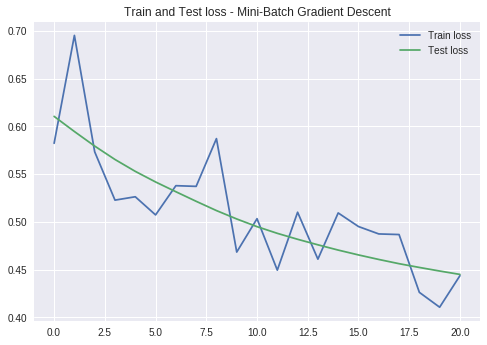

In [11]:
plt.plot(loss_train_history, label='Train loss')
plt.plot(loss_test_history, label='Test loss')
plt.title('Train and Test loss - Mini-Batch Gradient Descent')
plt.legend()
plt.show()

What can we infer from the Loss and Accuracy plots?

First of all, these results must not be taken too seriously: the breast cancer dataset is a very small toy dataset that I employed for educational purposes only. The performance of the model is not particularly interesting, since the whole training was repeated over just 21 epochs and on Mini-Batches of size 20. The goal of the present tutorial was just to show how Mini-Batch Gradient Descent can be implemented.

An interesting thing to note is the difference between Train and Test histories: while the Test series look smooth, the Train series are significantly more "noisy". This is the effect of Mini-Batch fetching: the random sampling of a Mini-Batch introduces *stochasticity* in the learning process. This is perfectly fine: the Train series of loss and accuracy look always noisier when using this sort of technique. This does not imply bad performances! Instead, on very large datasets Mini-Batch Gradient Descent algorithms usually outperform their full-Batch counterparts (and that's why I strongly suggest to use them).

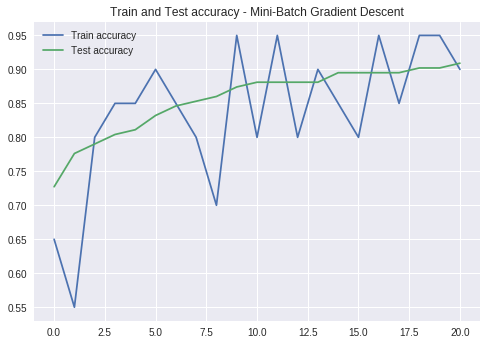

In [12]:
plt.plot(accuracy_train_history, label='Train accuracy')
plt.plot(accuracy_test_history, label='Test accuracy')
plt.title('Train and Test accuracy - Mini-Batch Gradient Descent')
plt.legend()
plt.show()

Now I'd like to check a Confusion Matrix:


In [13]:
# I transform the predictions of the Network in discrete probabilities
# that is because my prediction object contains float data. Instead, I need discrete [0 or 1] values for classification
# There are several ways, this is just one of the many
discrete_prediction = prediction

discrete_prediction = np.argmax(prediction, axis=1)   # this outputs a vector with the value of the class with the highest predicted probability [0 or 1]
discrete_testdata = np.argmax(y_test, axis=1)    # so I do it also for the test data

# plot the confusion matrix
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(discrete_prediction, discrete_testdata)
print(CM)

[[86 10]
 [ 3 44]]


The outcome of the Confusion Matrix seems very good. Most of the cases are on the have been classified correctly, i.e.: they are on the diagonal.

We can also plot it as a heatmap, which can be very useful in case you are working with a high number of classes.

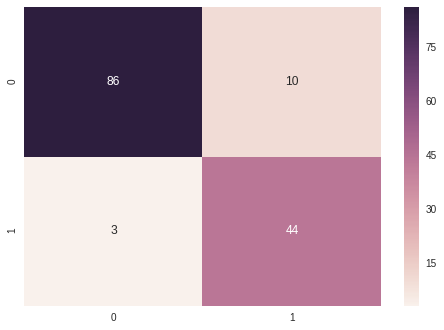

In [14]:
import seaborn

seaborn.heatmap(CM, annot=True)